In [1]:
import torch
from simple_vit import SimpleVisionTransformer
import torchvision.datasets as datasets
from torchvision.transforms import v2
from scipy.stats import entropy

In [12]:
import numpy as np

def gather_stats(ckpt_path):
    hidden_dim = 384
    input_resolution = 224
    
    vit = SimpleVisionTransformer(
        image_size=input_resolution,
        patch_size=16,
        num_layers=12,
        num_heads=6,
        hidden_dim=hidden_dim,
        mlp_dim=hidden_dim * 4
    )

    ckpt = torch.load(ckpt_path, weights_only=True)
    # vit.load_state_dict({k[len('module.'):]: v for k, v in ckpt['state_dict'].items()})
    vit.load_state_dict(ckpt['state_dict'])
    data = "/data/ImageNet/"
    value_range = v2.Normalize(
        mean=[0.5] * 3,
        std=[0.5] * 3
    )
    
    val_dataset = datasets.ImageNet(
        data,
        split='val',
        transform=v2.Compose([
            v2.ToImage(),
            v2.Resize(256),
            v2.CenterCrop(input_resolution),
            v2.ToDtype(torch.float32, scale=True),
            value_range,
        ])
    )

    batch_size = 128

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=4, pin_memory=True, sampler=None,
        multiprocessing_context='spawn'
    )

    device = torch.device("cuda")
    vit = vit.to(device)
    result = []

    for _, batch in enumerate(val_loader):
        images, target = batch
        images = images.to(device)
        target = target.to(device)
        images.requires_grad = True
        logits = vit(images)
        target_logits = logits[torch.arange(logits.shape[0]), target]
        total = sum(target_logits)
        total.backward()
        grad_sum_clipped = torch.clamp(images.grad.sum(dim=1), min=0.)
        grad_sum_clipped_normalized = grad_sum_clipped / grad_sum_clipped.sum(dim=(1, 2), keepdim=True)
        grad_sum_clipped_normalized = grad_sum_clipped_normalized.flatten(start_dim=1).cpu().numpy()
        result.append(entropy(grad_sum_clipped_normalized, axis=1))

    return np.concatenate(result)

In [13]:
# ckpt_path = "/data/imagenet-runs/logs/90ep-repo-attempt12/checkpoints/model_best.pth.tar"
# ckpt_path = "/data/imagenet-runs/logs/90ep-true-reproduction/checkpoints/model_best.pth.tar"
# ckpt_path = "/data/imagenet-runs/logs/linear-head-90ep/checkpoints/model_best.pth.tar"
ckpt_path = "/data/imagenet/05-15_2003/checkpoint.pth.tar"
result = gather_stats(ckpt_path)

In [14]:
USER = '** redacted **'

# filename = f"/home/{USER}/Downloads/90ep-repo-attempt12-entropy"
# filename = f"/home/{USER}/Downloads/90ep-true-reproduction-entropy"
# filename = f"/home/{USER}/Downloads/linear-head-90ep-entropy"
filename = f"/home/{USER}/Downloads/90ep-grafted-entropy"

np.save(filename, result)

In [15]:
result.shape

(50000,)

In [16]:
import numpy as np

attempt12 = np.load(f"/home/{USER}/Downloads/90ep-repo-attempt12-entropy.npy")
fixed_parallel = np.load(f"/home/{USER}/Downloads/linear-head-90ep-entropy.npy")
true_repro = np.load(f"/home/{USER}/Downloads/90ep-true-reproduction-entropy.npy")
grafted = np.load(f"/home/{USER}/Downloads/90ep-grafted-entropy.npy")

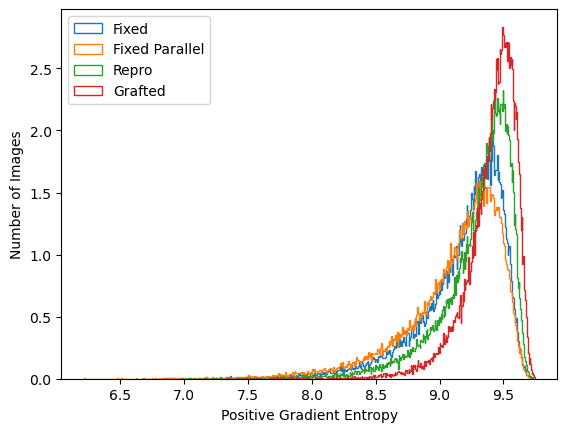

In [17]:
import matplotlib.pyplot as plt

plt.hist(attempt12, 500, density=True, histtype='step', label="Fixed")
plt.hist(fixed_parallel, 500, density=True, histtype='step', label="Fixed Parallel")
plt.hist(true_repro, 500, density=True, histtype='step', label="Repro")
plt.hist(grafted, 500, density=True, histtype='step', label="Grafted")

plt.legend(loc="upper left")
plt.xlabel("Positive Gradient Entropy")
plt.ylabel("Number of Images")
plt.savefig(f"/home/{USER}/Downloads/90ep-pixel-grad-comparison.png")
plt.show()